<a href="https://colab.research.google.com/github/mocccca/cmor438/blob/main/Supervised%20Learning/Neural%20Network/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilayer Neural Network

A **Multilayer Neural Network (MLNN)**, also known as a multilayer perceptron (MLP), is a type of feedforward artificial neural network that maps sets of input data to appropriate outputs through multiple layers of interconnected neurons.

It is a supervised learning model widely used for classification, regression, and pattern recognition tasks.



## General Process

1. **Input Layer**
   - Accepts the predictor variables (features).

2. **Hidden Layers**
   - One or more intermediate layers of neurons apply nonlinear transformations using activation functions (e.g., ReLU, tanh).
   - These layers enable the network to model complex, nonlinear relationships.

3. **Output Layer**
   - Produces the final prediction, depending on the task (e.g., a continuous value for regression, probabilities for classification).

4. **Training**
   - Uses **backpropagation** to update weights.
   - The network minimizes a loss function (e.g., mean squared error) through gradient descent or its variants.



## Advantages of Multilayer Neural Networks

- **Can Model Complex, Nonlinear Patterns**
  Captures relationships that simpler models (e.g., linear regression) miss.

- **Flexible Architecture**
  Supports varying numbers of layers and neurons, customizable for specific tasks.

- **Powerful for Both Regression and Classification**
  Applicable across a wide range of supervised learning problems.

- **Scalable to Large Datasets**
  Can handle large and high-dimensional data if sufficient computational resources are available.



## Disadvantages of Multilayer Neural Networks

- **Requires Careful Hyperparameter Tuning**
  Needs selection of layer sizes, learning rates, activation functions, etc.

- **Prone to Overfitting**
  Especially on small datasets, unless regularization (e.g., dropout) is applied.

- **Computationally Expensive**
  Training can be slow and resource-intensive.

- **Less Interpretable**
  Functions as a “black box” — difficult to extract intuitive insights from learned weights.



## Application

In this project, a multilayer neural network was used to predict participants’ **procrastination levels** based on composite psychological and behavioral measures.



### Predictor Variables

- `conscientiousness_composite`  
  Aggregate score reflecting the Big Five trait of conscientiousness.

- `depression_composite`  
  Composite score on participants' responses to 10 items measuring depression on Center for the Epidemiological Studies of Depression Short Form (CES-D-10; Andresen et al., 1994).

- `swb_composite`  
  Composite score on participants' responses to 5 items on Subjective Well-Being (SWB; Diener et al., 1985).

- `social_media_composite`  
  Measure of participants' usage and engagement with various social media platform.

- `dedication_composite`  
  Composite score on participants' responses to 3 items measuring Dedication on The Utrecht Work Engagement Scale (UWES-9; Schaufeli et al., 2002).

- `absorption_composite`  
  Composite score on participants' responses to 3 items measuring Absorption on The Utrecht Work Engagement Scale (UWES-9; Schaufeli et al., 2002).


### Target Variable

- `procrastination_composite`  
  Composite score reflecting individuals’ tendency to delay tasks or decisions, based on Procrastination (Tuckman et al., 1991).



### Goal

The goal was to apply a **multilayer neural network** to predict participants’ procrastination tendencies from a set of psychological and behavioral predictors.  
This approach aimed to model complex interactions between personality, well-being, and behavioral traits, potentially identifying nonlinear drivers of procrastination behavior.



In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
class ProcrastinationPredictor:
    def __init__(self, random_state=42):
        """Initialize the procrastination predictor model"""
        self.random_state = random_state
        self.scaler = StandardScaler()
        self.model = None
        self.history = None
        np.random.seed(random_state)
        tf.random.set_seed(random_state)

    def preprocess_data(self, X, y, test_size=0.2, val_size=0.2):
        """
        Preprocess data and split into train/val/test sets

        Args:
            X: Feature matrix (numpy array or pandas DataFrame)
            y: Target vector (numpy array or pandas Series)
            test_size: Proportion for test set
            val_size: Proportion for validation set (of remaining data after test split)

        Returns:
            X_train, X_val, X_test, y_train, y_val, y_test
        """
        # First split into train+val and test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, random_state=self.random_state)

        # Then split train+val into train and val
        val_size_adj = val_size / (1 - test_size)  # Adjust for previous split
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size_adj, random_state=self.random_state)

        # Standardize features
        self.scaler.fit(X_train)
        X_train = self.scaler.transform(X_train)
        X_val = self.scaler.transform(X_val)
        X_test = self.scaler.transform(X_test)

        return X_train, X_val, X_test, y_train, y_val, y_test

    def build_model(self, input_shape, l2_reg=0.01, dropout_rate=0.3):
        """Build the neural network architecture"""
        model = Sequential([
            Dense(64, activation='relu', input_shape=input_shape,
                  kernel_regularizer=l2(l2_reg)),
            BatchNormalization(),
            Dropout(dropout_rate),

            Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),
            BatchNormalization(),
            Dropout(dropout_rate/2),

            Dense(16, activation='relu'),
            BatchNormalization(),

            Dense(1)
        ])

        model.compile(optimizer='adam',
                     loss='mse',
                     metrics=['mae'])

        return model

    def train(self, X_train, y_train, X_val=None, y_val=None,
              epochs=200, batch_size=32, patience=20):
        """
        Train the neural network model

        Args:
            X_train: Training features
            y_train: Training target
            X_val: Validation features (optional)
            y_val: Validation target (optional)
            epochs: Maximum number of training epochs
            batch_size: Batch size for training
            patience: Patience for early stopping

        Returns:
            Training history
        """
        if self.model is None:
            self.model = self.build_model(input_shape=(X_train.shape[1],))

        callbacks = []
        if X_val is not None and y_val is not None:
            callbacks.append(
                EarlyStopping(monitor='val_loss', patience=patience,
                             restore_best_weights=True)
            )
            validation_data = (X_val, y_val)
        else:
            validation_data = None

        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_data,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate(self, X_test, y_test):
        """Evaluate model performance on test set"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")

        y_pred = self.model.predict(X_test).flatten()

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        return {
            'mse': mse,
            'mae': mae,
            'rmse': rmse,
            'predictions': y_pred,
            'true_values': y_test
        }

    def feature_importance(self, X, y, n_repeats=10, metric=mean_squared_error):
        """Calculate permutation feature importance"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")

        def scorer(estimator, X, y):
            return metric(y, estimator.predict(X).flatten())

        result = permutation_importance(
            self.model, X, y,
            n_repeats=n_repeats,
            random_state=self.random_state,
            scoring=scorer
        )

        return result

    def predict(self, X):
        """Make predictions on new data"""
        if self.model is None:
            raise ValueError("Model has not been trained yet")

        X_scaled = self.scaler.transform(X)
        return self.model.predict(X_scaled).flatten()

    def plot_history(self):
        """Plot training history"""
        if self.history is None:
            raise ValueError("Model has not been trained yet")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.ylabel('Loss (MSE)')
        plt.xlabel('Epoch')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['mae'], label='Train MAE')
        plt.plot(self.history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [50]:
# import data
url = "https://raw.githubusercontent.com/mocccca/cmor438/main/Leisure_Intereset_Dataset.csv"
li = pd.read_csv(url)
li1 = li[['conscientiousness_composite',
    'depression_composite',
    'swb_composite',
    'social_media_composite',
    'dedication_composite',
    'absorption_composite',
    'procrastination_composite'
]].copy()

predictor = li1[[
    'conscientiousness_composite',
    'depression_composite',
    'swb_composite',
    'social_media_composite',
    'dedication_composite',
    'absorption_composite'
]]
target = li1['procrastination_composite']

X = predictor
y = target

Training model...
Epoch 1/250


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - loss: 232.7138 - mae: 13.6074 - val_loss: 264.8151 - val_mae: 14.7293
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 225.7492 - mae: 13.5895 - val_loss: 264.0740 - val_mae: 14.7139
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 227.0142 - mae: 13.5716 - val_loss: 263.3961 - val_mae: 14.7002
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 221.6508 - mae: 13.5537 - val_loss: 262.7798 - val_mae: 14.6892
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 220.3789 - mae: 13.5357 - val_loss: 262.2780 - val_mae: 14.6795
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 217.7737 - mae: 13.5176 - val_loss: 261.6843 - val_mae: 14.6647
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 216.3716 - mae: 13.4995 - val_loss: 261.0399 - val_mae: 14.6482
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 215.7320 - mae: 13.4812 - val_loss: 260.3733 - val_mae: 14.6310
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━

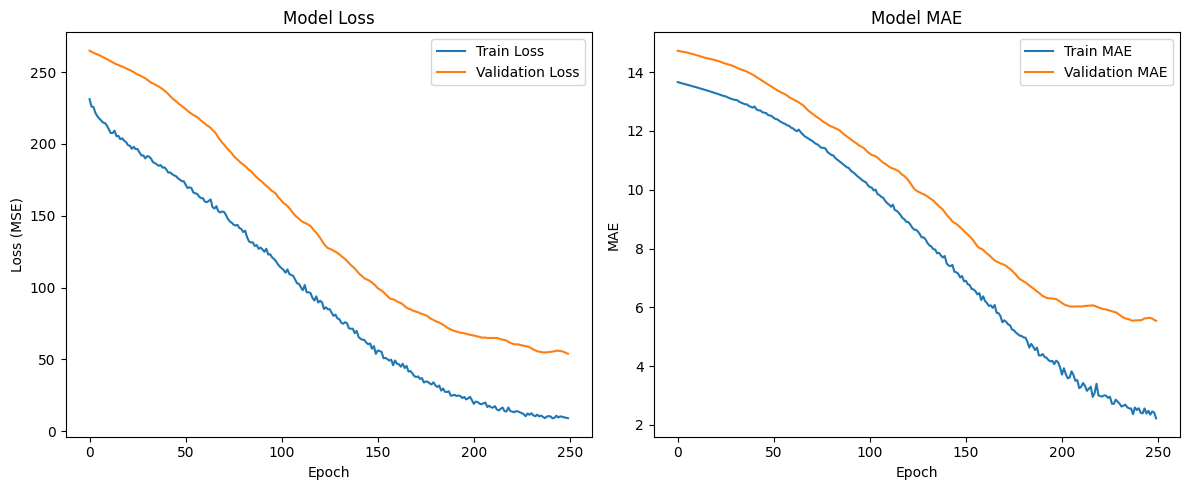

In [34]:
# STEP 3: Initialize and preprocess data
predictor = ProcrastinationPredictor(random_state=42)
X_train, X_val, X_test, y_train, y_val, y_test = predictor.preprocess_data(
    X, y, test_size=0.15, val_size=0.15)

# STEP 4: Train the model
print("Training model...")
history = predictor.train(X_train, y_train, X_val, y_val, epochs=250)

# STEP 5: Evaluate the model
results = predictor.evaluate(X_test, y_test)
print("\nTest Set Performance:")
print(f"MSE: {results['mse']:.4f}")
print(f"MAE: {results['mae']:.4f}")
print(f"RMSE: {results['rmse']:.4f}")

# STEP 6: Visualize training history
predictor.plot_history()

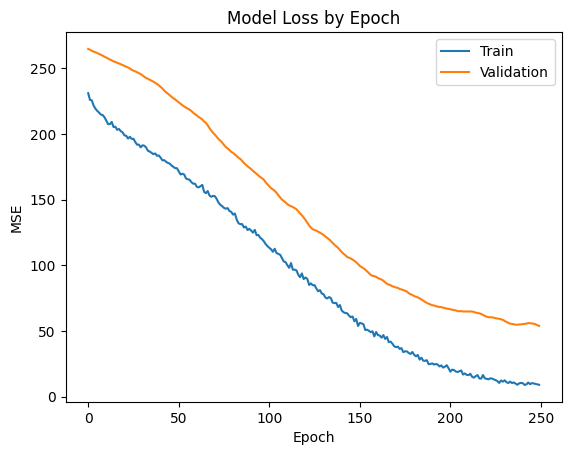

In [35]:
# Plot training vs validation loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss by Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()
plt.show()

epoch = 250 seems like a good choice.

In [37]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictor.predict(X_test))
print(f"Variance explained (R²): {r2:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Variance explained (R²): -0.04


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


this is weird...let's try another way to calculate the R² for this and compare how accurate the neural network is.

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
print("RF R²:", rf.score(X_test, y_test))

RF R²: 0.6019599689078896


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


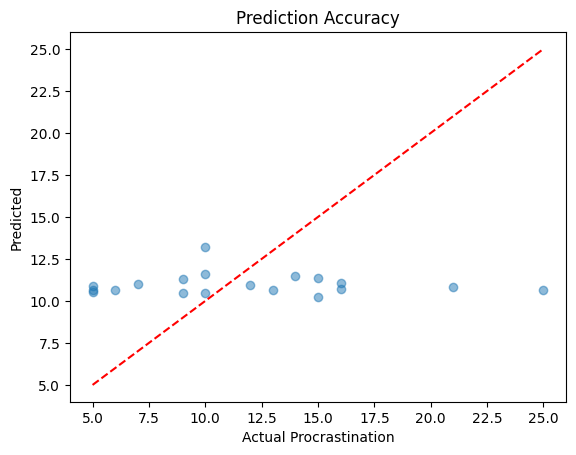

In [39]:
plt.scatter(y_test, predictor.predict(X_test), alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual Procrastination')
plt.ylabel('Predicted')
plt.title('Prediction Accuracy')
plt.show()

though having decent MAE/MSE scores, the neural network is likely overfitting to noise while missing the true signal.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


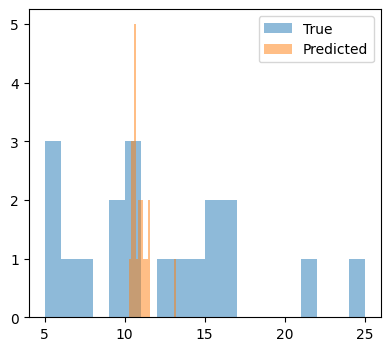

In [40]:
# Check prediction distribution vs actual
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_test, bins=20, alpha=0.5, label='True')
plt.hist(predictor.predict(X_test), bins=20, alpha=0.5, label='Predicted')
plt.legend()

despite decent MAE/MSE, the neural network is likely overfitting to noise while missing the true signal, presenting data leakage in preprocessing, and scaling some features incorrectly. so maybe other algorithms like random forest may be better to analyze this set of relations.

In [36]:
# STEP 7: Check feature importance
importance = predictor.feature_importance(X_test, y_test)
print("\nFeature Importance (higher = more important):")

# Make sure 'predictors' contains your feature names
predictors = [
    'conscientiousness_composite',
    'depression_composite',
    'swb_composite',
    'social_media_composite',
    'dedication_composite',
    'absorption_composite'
]

for i, feature_name in enumerate(predictors):
    print(f"{feature_name}: {importance.importances_mean[i]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━

the feature importance still provide us valuable insights into the correlations of personalities and psychological traits with procrastination that having higher subjective wellbeing, higher conscientiousness, and being deeply engrossed in activities --> less procrastination.